<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
#note
#Generate a gausspulse for testing?

We will be treating 2D arrays as rasters. Basically load any .csv, .txt or other file into a numpy  array as you would normally. Each entry should be the height data for it's respective pixel. 

Let's try out the simplest method, a text file containing an (M,N) array compatible with Numpy.
If you'd like to try your own data, simply change the file below and the loading function (e.g. if you have a .csv just change the delimeter in the np.loadtxt() call).

In [ ]:
file = 'BYGS008_top_segment_500samp_10cm_interp089.txt'
image = np.loadtxt(file)

Let's have a look at the image 

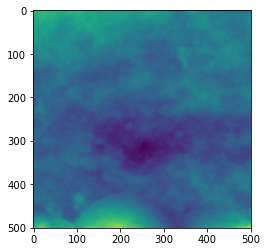

In [ ]:
plt.imshow(image)
plt.show()

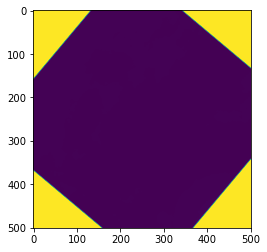

In [ ]:
image_45 = imutils.rotate(image, angle = 50)
plt.imshow(image_45)
plt.show()

In [ ]:
image.shape

(501, 501)

It can be very useful to study how roughness parameters change with regards to their orientation. The following function helps produce a range of profiles rotating around the central point of the image or array

In [1]:
#|output: asis
#| echo: false
show_doc(gen_rot_prof)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L18){target="_blank" style="float:right; font-size:smaller"}

### gen_rot_prof

>      gen_rot_prof (array, deg=180, increment=1)

Generates an array of rotational profiles through to deg, in even increments of increment. 
Uses OpenCV and Imutils to rotate the array around the center of the array/raster/image, extracts the middle row.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| array |  |  | 2D array of height values |
| deg | int | 180 | Number of degrees to rotate through, i.e 180 gives full 360 rotation |
| increment | int | 1 | indent/180 = number of evenly spaced profiles to calculate. |

Numpy likes the data in various forms for linear algebra, 
here is a helper to convert an (M,N) matrix into a (n,(X,Y,Z)) matrix. 

In [2]:
#|output: asis
#| echo: false
show_doc(image2xyz)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L41){target="_blank" style="float:right; font-size:smaller"}

### image2xyz

>      image2xyz (im)

Converts 2D (m,n) image/array to xyz coordinates. Used for plane levelling

In [3]:
#|output: asis
#| echo: false
show_doc(xyz2image)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L53){target="_blank" style="float:right; font-size:smaller"}

### xyz2image

>      xyz2image (xyz)

Helper to convert back from xyz (n,3) arrays to (M,N) image/matrices

|    | **Details** |
| -- | ----------- |
| xyz | (n,3) shape array |

In [ ]:
im_xyz = image2xyz(image)
im_xyz[:5]

array([[ 0.        ,  0.        , -0.89188266],
       [ 1.        ,  0.        , -0.8919338 ],
       [ 2.        ,  0.        , -0.89193225],
       [ 3.        ,  0.        , -0.89193505],
       [ 4.        ,  0.        , -0.89192402]])

In order to perform roughness calculations it is recommended to level the data and remove the underlying form.This produces a _S-F _surface from the *primary *surface if we are using Standards terms.  Here we construct a least-squares solution to the problem, computing the results in the same shape as the original image and subtract them. 

In [4]:
#|output: asis
#| echo: false
show_doc(remove_form)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L65){target="_blank" style="float:right; font-size:smaller"}

### remove_form

>      remove_form (im, degree=3, return_form=False)

Remove the form of the raster by fitting a polynomial of specified degree and subtracting it.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| im |  |  | 2D Numpy array or array like |
| degree | int | 3 | Polynomial degree to remove |
| return_form | bool | False | Return the form/computed polynomial values instead of removing them from im |

In [5]:
#|output: asis
#| echo: false
show_doc(plane_level)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L92){target="_blank" style="float:right; font-size:smaller"}

### plane_level

>      plane_level (im, norm=True, return_form=False)

Level an (m,n) array by computing the best fit plane and subtracting the results.
Thin wrapper around `remove_form` with degree = 1.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| im |  |  | Numpy array or array like |
| norm | bool | True | Normalize the data by subtracting the mean |
| return_form | bool | False |  |

In [ ]:
w = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
u = np.array([[1,0,-1]]*3)
test_close(plane_level(w), np.zeros(w.shape))
test_close(plane_level(u), np.zeros(u.shape))
test_fail(plane_level, kwargs = dict(xyz=np.array([1])))
test_fail(plane_level, kwargs = dict(xyz=np.array([[1,1]])))

Text(0.5, 1.0, 'Levelling plane')

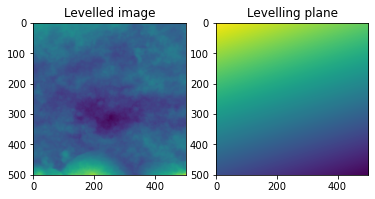

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(plane_level(image))
ax.set_title('Levelled image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(plane_level(image, return_form = True))
ax.set_title('Levelling plane')

Text(0.5, 1.0, 'Polynomial')

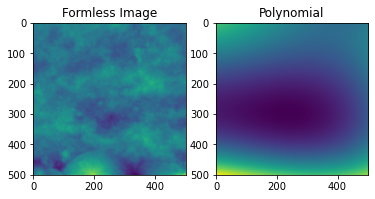

In [ ]:
image_f = remove_form(plane_level(image))
image_form = remove_form(plane_level(image), return_form = True)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f)
ax.set_title('Formless Image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(image_form)
ax.set_title('Polynomial')

In order to level our data we just:

Similarly, it is recommended to remove noise and attenuate high frequency features. We achieve this through the use of a gaussian filter. 

In [6]:
#|output: asis
#| echo: false
show_doc(smooth_image)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L106){target="_blank" style="float:right; font-size:smaller"}

### smooth_image

>      smooth_image (array, sigma=1, **kwargs)

Removes low frequency/wavelength features ('noise') by applying a gaussian filter on the image. 
Thin wrapper of scipy.ndimage.gaussian_filter.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| array |  |  | Numpy array or array like |
| sigma | int | 1 | Standard deviation for gaussian kernel Useful for determining the wavelength of the low pass filter |
| kwargs |  |  |  |

Text(0.5, 1.0, 'Sigma = 10')

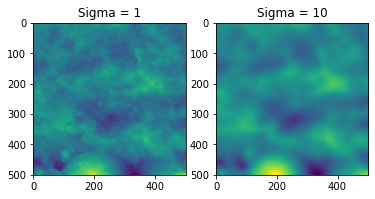

In [ ]:
image_f_s = smooth_image(image_f,sigma = 1)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f_s)
ax.set_title('Sigma = 1')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(smooth_image(image_f, sigma = 10))
ax.set_title('Sigma = 10')

In [7]:
#|output: asis
#| echo: false
show_doc(gen_sections)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/data.py#L117){target="_blank" style="float:right; font-size:smaller"}

### gen_sections

>      gen_sections (image, how='square', number=100)

Generates sections of the array/image, either in square, horizontal, or vertical sections.
Useful for studying the change of parameters over the surface.
Mostly wraps around np.hsplit and np.vsplit.
Note, if 'number' does not divide into the array evenly, the bottom/side remains will not be
included.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| image |  |  | 2D array (or arraylike) of height values |
| how | str | square | How to subdivide the array, options are: 'square', 'row', 'column' |
| number | int | 100 | Number of sections to produce |

In [ ]:
square = np.arange(0,36).reshape(6,6)
square.size

36

In [ ]:
square

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [ ]:
rowsec = np.array(gen_sections(square,how = 'row', number = 3))
#np.hsplit(rowsec,3)

In [ ]:
image_sections =  gen_sections(image)

Now, because we've applied all of our preprocessing steps to the original image. We can export it for use later.
We should also save our profiles and sections. The sections should be in .npy format because they are 3D.

In [ ]:
np.savetxt('example.txt', image_f_s)
np.savetxt('example_profiles.txt', gen_rot_prof(image_f_s))
np.save('example_sections.npy', image_sections)

And we can load them back in just to check.

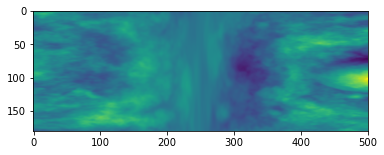

In [ ]:
profiles = np.loadtxt('example_profiles.txt')
plt.imshow(profiles)
plt.show()

# Utilities
> Various useful functions which are used elsewhere

In [8]:
#|output: asis
#| echo: false
show_doc(compute_parameters)

---

[source](https://github.com/kpjmcg/rough/blob/main/rough/cli.py#L20){target="_blank" style="float:right; font-size:smaller"}

### compute_parameters

>      compute_parameters (array, parameter_list:list, valid_module=None,
>                          to_df:bool=False, **kwargs)

Computes a set of parameters for a given array, provide a list of parameters (as strings of their respective functions e.g. ['Ra','Rms']) and a module
to verify against (might require some module aliasing, see CLI notebook for example use). Returns a list of results or a dataframe.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| array |  |  | Input array to be calculate parameters on |
| parameter_list | list |  | List of parameters to calculate as strings |
| valid_module | NoneType | None | module to generate functions from, used to check user input, see rough.cli:rough |
| to_df | bool | False | Return the parameters as a pandas dataframe, with columns set as the parameter names |
| kwargs |  |  |  |